In [1]:
import pandas as pd
from sqlalchemy import create_engine, inspect, types
from sqlalchemy.dialects.postgresql import insert
import os
from pathlib import Path
from dotenv import load_dotenv

base_dir = Path.cwd().parent
env_file = base_dir / '.env'
load_dotenv(env_file)
db_user = os.getenv("POSTGRES_USER")
db_pass = os.getenv("POSTGRES_PASSWORD")
db_host = "localhost"
db_name = os.getenv("POSTGRES_DB")

DB_CONN_STR = f"postgresql+psycopg2://{db_user}:{db_pass}@{db_host}:5432/{db_name}"

engine = create_engine(DB_CONN_STR)


In [2]:
def single_station_load(engine, station_id):
    query = "SELECT * FROM clean_station_data WHERE station_id=%(sid)s"
    params = {'sid': station_id}
    df_out = pd.read_sql(query, engine, params=params)
    return df_out

df_haifa = single_station_load(engine, 43)
df_tel_aviv = single_station_load(engine, 178)
df_afula = single_station_load(engine, 16)
df_afula.head()

,timestamp,rain,wsmax,wdmax,ws,stdwd,td,rh,tdmax,tdmin,ws1mm,ws10mm,u_vec,v_vec,rain_intensity_max,station_id,latitude,longitude
0,2019-12-31 22:00:00,0.0,1.4,322.0,0.666667,13.300000,8.833333,91.333333,9.5,8.1,1.3,1.2,0.312851,-0.347125,0.0,16,32.596,35.2769
1,2019-12-31 23:00:00,0.0,1.5,276.0,0.866667,11.416667,7.783333,97.166667,8.2,7.1,1.3,1.2,0.852835,0.133639,0.0,16,32.596,35.2769
2,2020-01-01 00:00:00,0.0,1.8,290.0,1.033333,13.050000,6.883333,99.833333,7.3,6.2,1.7,1.3,0.992793,0.091221,0.0,16,32.596,35.2769
3,2020-01-01 01:00:00,0.0,1.8,352.0,0.616667,24.750000,6.000000,100.000000,6.5,5.5,1.6,1.2,0.318678,0.120158,0.0,16,32.596,35.2769
4,2020-01-01 02:00:00,0.0,1.8,229.0,0.916667,14.600000,5.783333,100.000000,6.2,5.5,1.6,1.4,0.383916,0.733935,0.0,16,32.596,35.2769


In [3]:
print(df_afula.shape)
print(df_afula.columns.tolist())

(43848, 18)
['timestamp', 'rain', 'wsmax', 'wdmax', 'ws', 'stdwd', 'td', 'rh', 'tdmax', 'tdmin', 'ws1mm', 'ws10mm', 'u_vec', 'v_vec', 'rain_intensity_max', 'station_id', 'latitude', 'longitude']


In [4]:
def sort_by_ts(df: pd.DataFrame):
    df.set_index('timestamp', inplace=True)
    df.sort_index(axis=0, ascending=True, inplace=True)

sort_by_ts(df_afula)
sort_by_ts(df_tel_aviv)
sort_by_ts(df_haifa)

## Feature engineering functions (timelags/upstream)

In [5]:
def create_local_lags(df: pd.DataFrame, lag_hours=[1, 2, 3, 6, 12, 24]):
    """
    Creates autoregressive lag features for a single station's dataframe.
    Assumes df is already filtered for ONE station and sorted by time.
    """
    df_out = df.copy()
    target_cols = ['rain', 'u_vec', 'v_vec', 'td', 'rh', 'rain_intensity_max']

    for col in target_cols:
        if col in df_out.columns:
            for h in lag_hours:
                feat_name = f"{col}_t-{h}h"
                df_out[feat_name] = df_out[col].shift(h)


    df_out['target_rain_t+1'] = df_out['rain'].shift(-1)
    return df_out

In [6]:
def add_upstream_features(df_target: pd.DataFrame, df_upstream: pd.DataFrame, upstream_name, lag_hours=[1, 2, 3], join_type='inner'):
    """
    Joins upstream station data onto the target station.
    """
    force_cols = ['rain', 'u_vec', 'v_vec']
    renamed_cols = {c: f"{c}_{upstream_name}" for c in force_cols}
    df_force = df_upstream[force_cols].rename(columns=renamed_cols).copy()
    
    for col, new_name in renamed_cols.items():
        for h in lag_hours:
            df_force[f"{new_name}_t-{h}h"] = df_force[new_name].shift(h)

    df_merged = df_target.join(df_force, how=join_type)
    
    return df_merged

## Data splitting with time-series preservation

In [7]:
def temporal_split(df: pd.DataFrame, target_col, val_start_date, test_start_date):
    """
    Splits time-series data into training/validation/testing sets
    
    :param df: Pandas DataFrame
    :param val_start_date: String representation 'yyyy-mm-dd'
    :param test_start_date: String representation 'yyyy-mm-dd'

    Returns:
        SplitDataFrames: X_train, X_val, X_test, y_train, y_val, y_test
    """
    feature_cols = [c for c in df.columns if c != target_col]
    X = df[feature_cols]
    y = df[target_col]

    X_train = X[X.index < val_start_date]
    y_train = y[y.index < val_start_date]

    mask_val = (X.index >= val_start_date) & (X.index < test_start_date)
    X_val = X[mask_val]
    y_val = y[mask_val]

    X_test = X[X.index >= test_start_date]
    y_test = y[y.index >= test_start_date]

    return X_train, X_val, X_test, y_train, y_val, y_test


Simple dataframe processing to remove structural nulls

In [8]:
def prepare_dataset(df, target_col='target_rain_t+1', max_lag=6):
    df_lagged = create_local_lags(df)
    df_trimmed = df_lagged.iloc[max_lag:]
    df_final = df_trimmed.dropna(subset=[target_col])
    
    return df_final

**Constructing DataFrames**

In [9]:
# Here we construct the master time index to join other tables on it
# This allows us to preserve the temporal structure of the dataset

def create_production_backbone(raw_start_str, raw_end_str, max_lag_hours, freq='h'):
    """
    Creates a Master Time Index that starts EXACTLY after the warm-up period.
    This ensures every row in the resulting dataframe is valid for inference.
    """
    t0 = pd.Timestamp(raw_start_str)
    tend = pd.Timestamp(raw_end_str)
    
    effective_start = t0 + pd.Timedelta(hours=max_lag_hours)
    
    print(f"Raw Start:      {t0}")
    print(f"Warmup Period:  {max_lag_hours} hours")
    print(f"Index Starts:   {effective_start} (First Predictable Row)")
    
    master_index = pd.date_range(start=effective_start, end=tend, freq=freq)
    
    df_master = pd.DataFrame(index=master_index)
    df_master.index.name = 'timestamp'
    
    return df_master


df_backbone = create_production_backbone(
    raw_start_str="2020-01-01 00:00:00",
    raw_end_str="2025-01-01 00:00:00",
    max_lag_hours=24
)

df_backbone.head()

Raw Start:      2020-01-01 00:00:00
Warmup Period:  24 hours
Index Starts:   2020-01-02 00:00:00 (First Predictable Row)


""
timestamp
2020-01-02 00:00:00
2020-01-02 01:00:00
2020-01-02 02:00:00
2020-01-02 03:00:00
2020-01-02 04:00:00


In [10]:
df_afula_lags = prepare_dataset(df_afula, target_col='target_rain_t+1', max_lag=24)
df_afula_lags = (df_backbone.join(df_afula_lags, how='left')).dropna(subset=['target_rain_t+1'])

df_afula_lags_upstream_TA = add_upstream_features(
    df_afula_lags,
    df_tel_aviv,
    upstream_name="tel_aviv",
    join_type='left'
)

df_afula_lags_upstream_TA_HA = add_upstream_features(
    df_afula_lags_upstream_TA,
    df_haifa,
    upstream_name="haifa",
    join_type='left'
)

## XGBoost no feature engineering

In [11]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error

val_start_date = '2023-01-01'
test_start_date = '2024-01-01'

X_train, X_val, X_test, y_train, y_val, y_test = temporal_split(
    df_afula_lags,
    'target_rain_t+1',
    val_start_date,
    test_start_date
)

basic_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    objective='reg:squarederror',
    n_jobs=-1,
    missing=np.nan,
    early_stopping_rounds=50
)

basic_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

preds_test = basic_model.predict(X_test)

## XGBoost with upstream features and feature engineering

With telaviv only

In [12]:
X_train, X_val, X_test, y_train, y_val, y_test = temporal_split(
    df_afula_lags_upstream_TA,
    'target_rain_t+1',
    val_start_date,
    test_start_date
)

boosted_model1 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    objective='reg:squarederror',
    n_jobs=-1,
    early_stopping_rounds=50,
    missing=np.nan,
    monotone_constraints={"rain_tel_aviv": 1}
)

boosted_model1.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

preds_test_boosted1 = boosted_model1.predict(X_test)

With haifa and telaviv

In [13]:
X_train, X_val, X_test, y_train, y_val, y_test = temporal_split(
    df_afula_lags_upstream_TA_HA,
    'target_rain_t+1',
    val_start_date,
    test_start_date
)

boosted_model2 = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    objective='reg:squarederror',
    n_jobs=-1,
    early_stopping_rounds=50,
    missing=np.nan,
    monotone_constraints={"rain_tel_aviv": 1, "rain_haifa": 1}
)

boosted_model2.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

preds_test_boosted2 = boosted_model2.predict(X_test)

**BASELINE 0 Complexity Model**

In [14]:
preds_presistence = X_test['rain']

Conditional RMSE

In [15]:
def storm_rmse(y_pred, y_test, model_name):
    mask_rainy = y_test > 0.1

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(model_name + ':')
    print(f"GLOBAL t+1 RMSE: {rmse:.4f} mm")

    if mask_rainy.sum() > 0:
        y_rainy = y_test[mask_rainy]
        pred_rainy = y_pred[mask_rainy]
        rmse_rainy = np.sqrt(mean_squared_error(y_rainy, pred_rainy))
        print(f"Storm-Only t+1 RMSE: {rmse_rainy:.4f} mm")
        print()
    else:
        print("No rain events in the test set!")


# On our baseline presistence model
storm_rmse(preds_presistence, y_test, 'Baseline Persistence')

# On our baseline XGBoost
storm_rmse(preds_test, y_test, 'Baseline XGBoost')

# On our XGBoost with upstream from Telaviv
storm_rmse(preds_test_boosted1, y_test, 'XGBoost upstream Telaviv')

# On our XGBoost with upstream from Telaviv and Haifa
storm_rmse(preds_test_boosted2, y_test, 'XGBoost upstream Telaviv Haifa')

Baseline Persistence:
GLOBAL t+1 RMSE: 0.5996 mm
Storm-Only t+1 RMSE: 2.7222 mm

Baseline XGBoost:
GLOBAL t+1 RMSE: 0.4884 mm
Storm-Only t+1 RMSE: 2.3056 mm

XGBoost upstream Telaviv:
GLOBAL t+1 RMSE: 0.4769 mm
Storm-Only t+1 RMSE: 2.2326 mm

XGBoost upstream Telaviv Haifa:
GLOBAL t+1 RMSE: 0.4592 mm
Storm-Only t+1 RMSE: 2.1563 mm



## Plotting feature importances and impacts

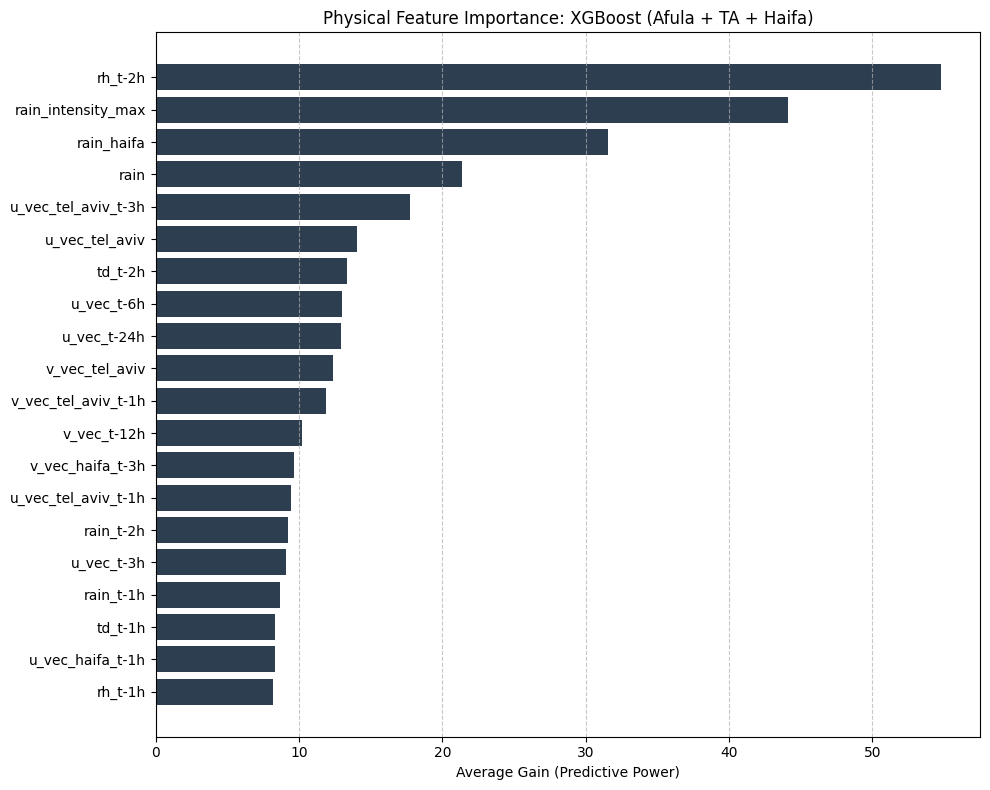

In [16]:
import matplotlib.pyplot as plt

def plot_physical_importance(model, model_name):
    # 'gain' = Average improvement in accuracy brought by a feature
    importance = model.get_booster().get_score(importance_type='gain')
    
    # Sort and take top 20 for readability
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:20]
    
    features, scores = zip(*sorted_importance)
    
    plt.figure(figsize=(10, 8))
    plt.barh(features, scores, color='#2c3e50')
    plt.xlabel('Average Gain (Predictive Power)')
    plt.title(f'Physical Feature Importance: {model_name}')
    plt.gca().invert_yaxis()  # Highest importance at top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Run on your final spatial model
plot_physical_importance(boosted_model2, "XGBoost (Afula + TA + Haifa)")

Binary representation of model's accuracy for precipitation

In [17]:
from sklearn.metrics import classification_report

thresh = 0.5
y_test_bin = (y_test > thresh).astype(int)
preds_bin = (preds_test_boosted2 > thresh).astype(int)

print(classification_report(y_test_bin, preds_bin, target_names=['Dry', 'Rain']))

              precision    recall  f1-score   support

         Dry       0.99      0.98      0.98      8527
        Rain       0.49      0.67      0.56       254

    accuracy                           0.97      8781
   macro avg       0.74      0.82      0.77      8781
weighted avg       0.98      0.97      0.97      8781



These metrics indicate a safety-biased configuration suitable for operational hazard warning. While the model accepts a ~50% False Alarm Ratio (Precision = 0.49), this trade-off allows it to successfully detect 68% of all storm events (Recall = 0.68). The F1-Score of 0.57 confirms the model possesses genuine predictive skill and is not overfitting to the dominant dry periods (class imbalance).

**Checking timestamp continuity from start to end**

In [24]:
def check_timestamp_holes(df, freq='h'):
    """
    Checks if a DataFrame index has any missing timestamps (holes).
    """
    if df.empty:
        print("DataFrame is empty!")
        return

    if not isinstance(df.index, pd.DatetimeIndex):
        try:
            df.index = pd.to_datetime(df.index)
        except:
            print("Error: Index is not datetime and cannot be converted.")
            return

    start_time = df.index.min()
    end_time = df.index.max()
    perfect_index = pd.date_range(start=start_time, end=end_time, freq=freq)

    missing_timestamps = perfect_index.difference(df.index)

    if len(missing_timestamps) == 0:
        print(f"SUCCESS: No holes found. Timeline is continuous from {start_time} to {end_time}.")
        print(f"Total rows: {len(df)}")
    else:
        print(f"WARNING: Found {len(missing_timestamps)} missing timestamps!")
        print("First 5 missing holes:")
        print(missing_timestamps[:5])


check_timestamp_holes(df_afula_lags_upstream_TA_HA, freq='h')

SUCCESS: No holes found. Timeline is continuous from 2020-01-02 00:00:00 to 2024-12-31 20:00:00.
Total rows: 43821
